# Alignment Metrics

This notebook contains an example of how to input an alignment and run the different metrics on it. The metrics contained in the RAID tool:


 - Curvature 
 - Permissible Speed
 - Actual Speed
 - Gradient
 - Ground Elevation
 - Alignment Elevation

In [1]:
import os
import geopandas as gpd
import sys
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import gdal
import numpy as np

cwd=os.getcwd()
src=os.path.dirname(cwd)
#append the path to the PYTHONPATH
sys.path.insert(0, src)

from raidnr.config import CRS, GRANULARITY, METRICS, PATH_RAILWAY
from raidnr.util.ext_methods import purge_poly, resample_poly, reconstruct_poly, fetch_shp, load_speed_limits
from raidnr.core.alignment import Alignment
import raidnr.util.SpatialToolbox as st
import raidnr.bwgrid.grid_transformations as gt
from raidnr.bwgrid.grid import Grid

# Insert data and create the Alignment object

### Alignment


The first step is to import the alignment we wish to analyse. The input data is a shapefile layer. 
The algorithm will then process the line features to by resampling and populating points every 3 metres 
and consttructing one shapely.geometry.LineString object as result.

**_Note that alignments that have branches/intersections cannot be processed by the tool at the moment._**

In [4]:
#recreate the line using interpolation 

#Import data
pl=purge_poly(os.path.join(src,"flask_UI",'InputData','shp','Railway_Lines','Manchester_York_Simple_Left_Line.shp'))['geometry'][0]

#Resample
pl=resample_poly(pl,300) 

#Re-construct
a=reconstruct_poly(pl,3) #reconstruct

#Store the re-construced line as a shapely LineString 
newLine=LineString(a) 

In [5]:
#Create the Alignment object
alignment=Alignment(newLine,0,3.0)

#If we want to know all the parameters that are required for the class, type the following:
#Alignment?

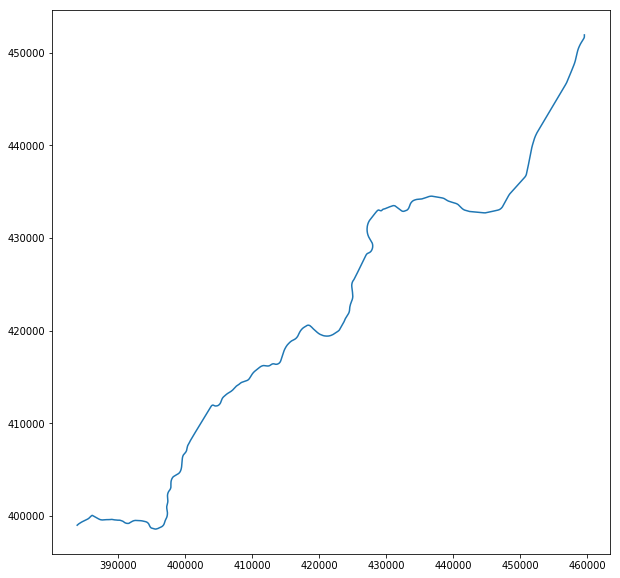

In [6]:
# Let's plot the alignment that we will analyse
#Using the class function
alignment.plot()

# or we can use matplotlib to plot it
# ax,fig = plt.subplots(figsize = (14,12))
# x = a[:,0]
# y = a[:,1]
# plt.plot(x,y)

### Grid

Since we are calculating the ground elevation values for the specific we will need the Digital Terrain Model data for the area.

In [17]:
raster = os.path.join(cwd,'notebook_data',"alignment_metrics",'DTM.tif')
raster_out = os.path.join(cwd,'results','output_DTM.tif')
bbox_example = os.path.join(cwd,'results','bbox.shp')

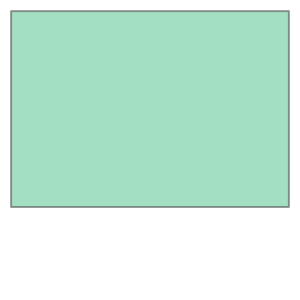

In [14]:
# We will get the bounds of the line to create the Grid class object
minx,miny,maxx,mxay = newLine.bounds

st.fromCoordsToBbox(minx,miny,maxx,mxay,os.path.join(cwd,'results'))

In [18]:
ds = gdal.Open(raster)
raster_size=(ds.RasterYSize,ds.RasterXSize)

dtm_array = ds.ReadAsArray()

print(" Raster dimensions",raster_size)

dtm_array = dtm_array.astype('float64')

grid = Grid(dtm_array,np.array(newLine.bounds),3.0)

st.clip_raster(bbox_example,raster,raster_out)

 Raster dimensions (1368, 2872)


# Run the metrics 

The metrics can be calculated either by calling a single function for all the metrics
    
    
#### METRICS
    
 - curvature
 - permissible_speed
 - actual_speed
 - elevation_difference
 - ground_elevation
 - alignment_elevation
 - gradient_ratio
 - gradient_pct
 - gradient_smooth
 - gradient_labels

Or they can be calculated individually by calling the relevant functions each time.
  

In [100]:
#all_metrics = alignment.run_metrics()

In [101]:
# alignment.cut_fill(dtm_array)

In [98]:
alignment.to_raster_coords_Alignment(grid)

**_Important Note_**

- For permissible speed and/or actual speed we will need to calculate first the curvature.
- For the gradient, the cut & fill should be calculated first.


In [19]:
curvature = alignment.curvature_analysis()

permis_speed = alignment.permissible_speed_analysis()

actual_speed = alignment.actual_speed_analysis()

# cut_fill = alignment.cut_fill()

# gradient = alignment.extract_slope()



C:\Users\brydenwood\Desktop\test_projects\19029_raid_nr\raidnr\util\ext_methods.py:259: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt((a+(b+c))*(c-(a-b))*(c+(a-b))*(a+(b-c))) / 4.
C:\Users\brydenwood\Desktop\test_projects\19029_raid_nr\raidnr\util\ext_methods.py:265: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./curvature
C:\Users\brydenwood\Desktop\test_projects\19029_raid_nr\raidnr\util\ext_methods.py:291: RuntimeWarning: invalid value encountered in double_scalars
  r = np.sum(a[max(0,n-ii):ii+n]) / ((ii+n) - max(0,n-ii))


# Plot the metrics

In [26]:
# We can use the class function to plot all the calculated metrics
alignment.plot_metrics()


In [ ]:
# plot the actual and permissible speed on the same graph
